# Решение

## Подготовка

Импортируем необходимые для начала работы библиотеки

In [1]:
import os
import numpy as np
import pandas as pd

Определяем папку, где находятся данные

In [2]:
data_dir = os.path.join('..', 'data')

Загружаем данные

In [3]:
users_df = pd.read_csv(os.path.join(data_dir, 'users.tsv'), sep='\t')
history_df = pd.read_csv(os.path.join(data_dir, 'history.tsv'), sep='\t')
validate_df = pd.read_csv(os.path.join(data_dir, 'validate.tsv'), sep='\t')
validate_answers_df = pd.read_csv(os.path.join(data_dir, 'validate_answers.tsv'), sep='\t')

## Работа с "Историей"

Чтобы удобнее было перезапускать частично, периодически будем копировать датафреймы

In [4]:
history = history_df.copy()

Проходимся по датафрейму и агрегируем необходимые нам данные

Можно заменить на вызовы методов датафреймов для необходимых агрегаций, но мне показалось, что так может быть быстрее

Основные показатели которые нам нужны - набор выигравших cpm для каждого пользователя и распределение пользователей по площадкам 

In [5]:
user_cpms = {}
publisher_users = {}

for index, row in history.iterrows():
    user_id = str(int(row['user_id']))
    publisher = str(int(row['publisher']))
    cpm = row['cpm']

    if user_id not in user_cpms:
        user_cpms[user_id] = []
    user_cpms[user_id].append(cpm)

    if publisher not in publisher_users:
        publisher_users[publisher] = set()
    publisher_users[publisher].add(user_id)

## Работа с "Рекламой"

Аналогично копируем датафрейм

In [6]:
ads = validate_df.copy()
ads_len = ads.shape[0]

Из анализа мы определили, что есть "пиковые часы" 8-22, мне кажется их можно использовать для создания фичей

In [7]:
def peak_hours(hour_start, hour_end):
    peak_hours_count = 0
    for i in range(hour_start, hour_end + 1):
        hour_norm = i % 24
        if hour_norm >= 8 and hour_norm <= 22:
            peak_hours_count += 1
    return peak_hours_count

Создаем фичи  
В принципе тут можно без комментариев понять по названиям

In [8]:
ads['publisher_size'] = ads['publishers'].apply(lambda publishers: len(publishers.split(',')))
ads['peak_hours'] = ads.apply(lambda row: peak_hours(row['hour_start'], row['hour_end']), axis=1)
ads['cpm_x_peak_hours'] = ads['cpm'] * ads['peak_hours']
ads['publisher_size_x_peak_hours'] = ads['publisher_size'] * ads['peak_hours']

Далее мы начинаем обходить для каждого рекламного объявления пользователей, которые в нем указаны и создаем фичи на их основе

Как показала практика это одни из самых значимых фичей

`users_power` - это показатель того, сколько человек смотрит рекламы  
не придумал более хорошего названия

In [9]:
ads['users_power'] = np.zeros_like(ads_len, dtype=np.float64)
ads['mean_users_power'] = np.zeros_like(ads_len, dtype=np.float64)
ads['mean_cpm_per_users'] = np.zeros_like(ads_len, dtype=np.float64)

for index, row in ads.iterrows():
    users = row['user_ids'].split(',')
    counts = []
    cpms = []
    for user in users:
        if user in user_cpms:
            counts.append(len(user_cpms[user]))
            cpms.extend(user_cpms[user])
    ads.at[index, 'users_power'] = sum(counts)
    ads.at[index, 'mean_users_power'] = np.mean(counts)
    ads.at[index, 'mean_cpm_per_users'] = np.mean(cpms)

Здесь примерно то же самое, только обходим по площадкам

In [10]:
ads['active_users_in_publishers'] = np.zeros_like(ads_len)
ads['mean_active_users_in_publishers'] = np.zeros_like(ads_len, dtype=np.float64)

for index, row in ads.iterrows():
    publishers = row['publishers'].split(',')
    counts = []
    for publisher in publishers:
        if publisher in publisher_users:
            counts.append(len(publisher_users[publisher]))
    ads.at[index, 'active_users_in_publishers'] = sum(counts)
    ads.at[index, 'mean_active_users_in_publishers'] = np.mean(counts)

## Завершение обработки данных

Далее будем приводить всё к виду, в котором будет удобно скармливать данные модели

In [11]:
target = validate_answers_df.copy()['at_least_one']

In [12]:
features = ads.copy()

Тут удаляем совсем неподходящие (по типу) колонки

In [13]:
features = features.drop(columns=['user_ids', 'publishers'])

Тут удаляем уже те, которые нам не нравятся (по влиянию на модель)

In [14]:
features = features.drop(columns=['hour_start', 'hour_end'])

Вот что у нас получилось по составу колонок

In [15]:
features.columns

Index(['cpm', 'audience_size', 'publisher_size', 'peak_hours',
       'cpm_x_peak_hours', 'publisher_size_x_peak_hours', 'users_power',
       'mean_users_power', 'mean_cpm_per_users', 'active_users_in_publishers',
       'mean_active_users_in_publishers'],
      dtype='object')

Посмотрим на матрицу корреляций

In [16]:
corr = features.corr()
corr.style.background_gradient(cmap='coolwarm')

,cpm,audience_size,publisher_size,peak_hours,cpm_x_peak_hours,publisher_size_x_peak_hours,users_power,mean_users_power,mean_cpm_per_users,active_users_in_publishers,mean_active_users_in_publishers
cpm,1.000000,-0.000887,0.026065,-0.012519,0.414271,0.008217,0.010567,0.002696,0.037102,0.017504,-0.015117
audience_size,-0.000887,1.000000,0.025797,0.014840,0.022473,0.014297,0.521994,0.048228,-0.002968,-0.020482,-0.050152
publisher_size,0.026065,0.025797,1.000000,-0.037479,-0.000732,0.278517,-0.020791,-0.046162,0.028412,0.517861,-0.364333
peak_hours,-0.012519,0.014840,-0.037479,1.000000,0.738799,0.874611,0.039895,0.060199,0.008698,-0.025915,0.005092
cpm_x_peak_hours,0.414271,0.022473,-0.000732,0.738799,1.000000,0.668658,0.035554,0.057024,-0.000511,0.003795,0.012754
publisher_size_x_peak_hours,0.008217,0.014297,0.278517,0.874611,0.668658,1.000000,0.031866,0.046068,0.019122,0.138881,-0.103672
users_power,0.010567,0.521994,-0.020791,0.039895,0.035554,0.031866,1.000000,0.778316,-0.212048,-0.023681,-0.026245
mean_users_power,0.002696,0.048228,-0.046162,0.060199,0.057024,0.046068,0.778316,1.000000,-0.318550,-0.008926,0.026776
mean_cpm_per_users,0.037102,-0.002968,0.028412,0.008698,-0.000511,0.019122,-0.212048,-0.318550,1.000000,-0.016837,-0.045344
active_users_in_publishers,0.017504,-0.020482,0.517861,-0.025915,0.003795,0.138881,-0.023681,-0.008926,-0.016837,1.000000,0.493366


Видно, что некоторые признаки сильно коррелируют, но я не стал их убирать пока, потому что они всё равно полезны для метрики

Делим на train и test

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

## Работа с моделью

Почему CatBoostRegressor? Потому что неплохой результат сходу (лучше чем у xgboost), и потому что я пока не успел попробовать другие модели (кроме xgboost)

In [18]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(X_train, y_train)

Learning rate set to 0.038478
0:	learn: 0.1457289	total: 144ms	remaining: 2m 24s
1:	learn: 0.1423073	total: 146ms	remaining: 1m 12s
2:	learn: 0.1387375	total: 148ms	remaining: 49.2s
3:	learn: 0.1355043	total: 151ms	remaining: 37.5s
4:	learn: 0.1320323	total: 154ms	remaining: 30.6s
5:	learn: 0.1291112	total: 157ms	remaining: 26s
6:	learn: 0.1262266	total: 159ms	remaining: 22.6s
7:	learn: 0.1230144	total: 161ms	remaining: 20s
8:	learn: 0.1198795	total: 164ms	remaining: 18s
9:	learn: 0.1174877	total: 166ms	remaining: 16.4s
10:	learn: 0.1147863	total: 167ms	remaining: 15s
11:	learn: 0.1123464	total: 169ms	remaining: 13.9s
12:	learn: 0.1097221	total: 171ms	remaining: 13s
13:	learn: 0.1074650	total: 172ms	remaining: 12.1s
14:	learn: 0.1052958	total: 173ms	remaining: 11.4s
15:	learn: 0.1030490	total: 175ms	remaining: 10.7s
16:	learn: 0.1009929	total: 176ms	remaining: 10.2s
17:	learn: 0.0987677	total: 177ms	remaining: 9.66s
18:	learn: 0.0968370	total: 178ms	remaining: 9.21s
19:	learn: 0.094921

Да, вот так просто залили без доп настроек  
В будущем конечно надо оптимизировать гиперпараметры

Посмотрим на значимость фичей

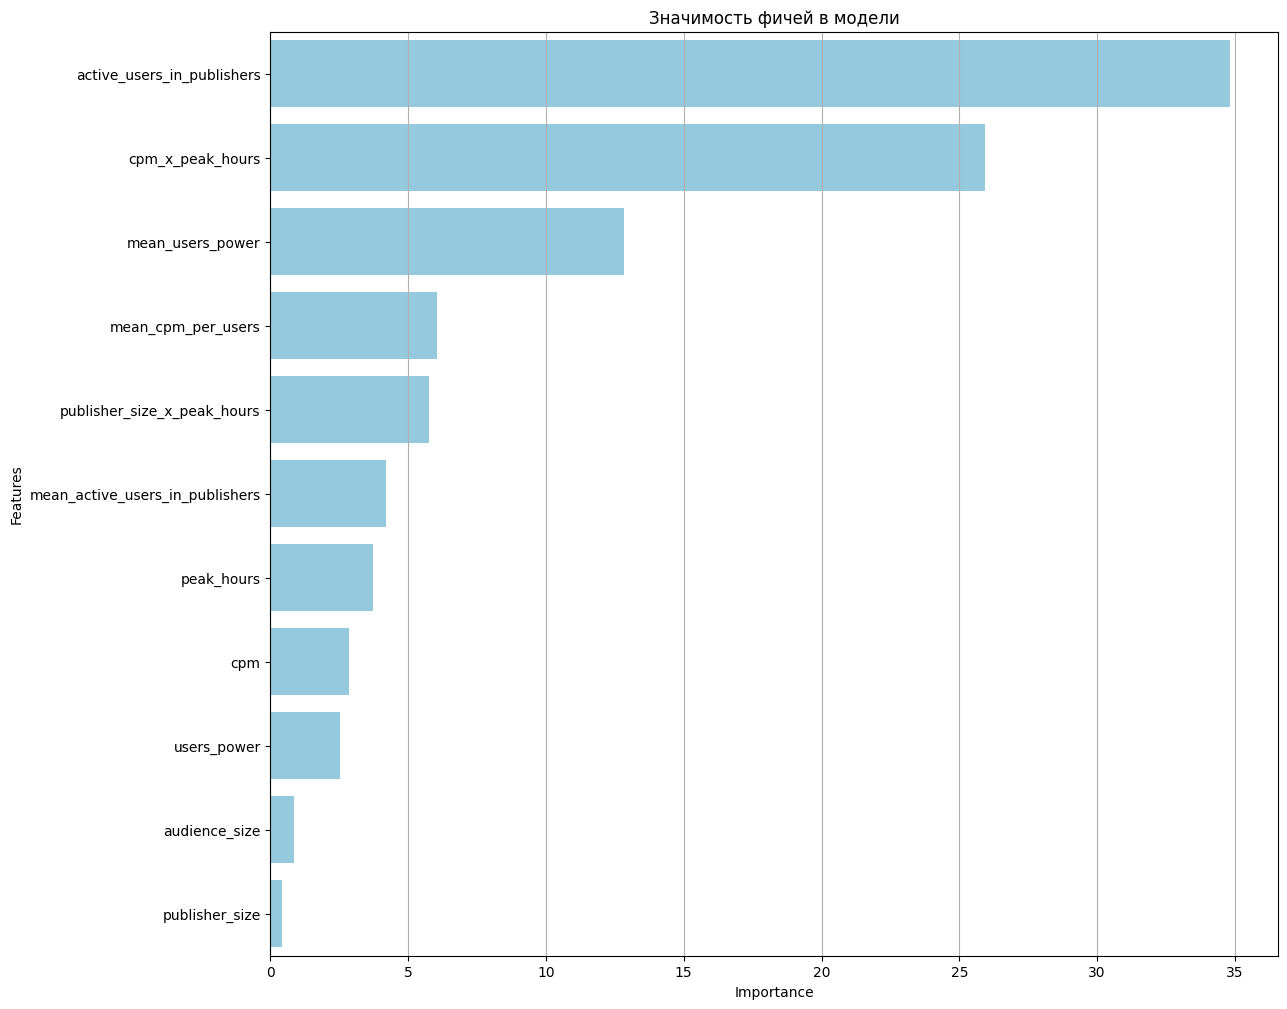

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

feats = {}
for feature, importance in zip(X_train.columns, model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
plt.figure(figsize=(13, 12))
plt.grid(True)
sns.barplot(x=importances['Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.title('Значимость фичей в модели')
plt.show()

Можно убрать малозначимые и добавить каких-нибудь еще интересных

Я пробовал перемножать и делить базовые фичи (cpm, duration, sizes), но там ничего супер полезного не было

Функцию написал для того, чтобы в будущем легче было сравнивать модели, но пока не пригодилось

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")

Посчитаем метрику на test

In [21]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

print_metrics(y_true, y_pred)

MAE: 0.0193
MSE: 0.0010
RMSE: 0.0309
R2: 0.9509


Неплохо  
У меня получалось лучше, но там было в 2 раза больше малополезных фичей, а результат не сильно отличался  